# Предсказание коэффициента восстановления золота из золотосодержащей руды

Необходимо подготовить прототип модели машинного обучения, которая предсказывает коэффициент восстановления золота из золотосодержащей руды.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.dummy import DummyRegressor
from numpy.random import RandomState
state = np.random.RandomState(12345)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Подготовка данных

### Откроем файлы с данными и изучим общую информацию

In [2]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
except:
    df_train = pd.read_csv('gold_recovery_train_new.csv')

In [3]:
try:
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    df_test = pd.read_csv('gold_recovery_test_new.csv')

In [4]:
try:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    df_full = pd.read_csv('gold_recovery_full_new.csv')

In [5]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info(), display(df.describe()) 
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df.duplicated().sum()))

In [6]:
review(df_full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Дубликатов не обнаружено


In [7]:
review(df_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Дубликатов не обнаружено


In [8]:
review(df_test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


Дубликатов не обнаружено


#### Вывод

Видим:
- характеристики металлов на каждом этапе до и после прохождения определенного этапа;
- расчетные характеристики на первом этапе;
- характеристики отвальных хвостов после каждого этапа;
- характеристиках поданных реагентах;
- номер и характеристики флотационных установок;
- все три выборки содержат пустые значения;
- дубликатов в выборках не обнаружено.

### Проверим, что эффективность обогащения расчитана правильно.

Для этого, вычислим её на обучающей выборке - `df_train` для признака `rougher.output.recovery`. Посмотрим на `MAE` между расчётами и значением признака.

Эффективность обогащения рассчитывается по формуле:

# $Recovery = \frac{C * (F - T)}{F * (C - T)} * 100$

где:
- `C` — доля золота в концентрате после флотации/очистки;
- `F` — доля золота в сырье/концентрате до флотации/очистки;
- `T` — доля золота в отвальных хвостах после флотации/очистки.

In [9]:
def efficiency_check(row_1, row_2, row_3):
    """функция расчета эффективности обогащения"""
    check = ((row_1 * (row_2 - row_3)) / (row_2 * (row_1 - row_3))) * 100
    return check

In [10]:
test = efficiency_check(df_train['rougher.output.concentrate_au'], 
                        df_train['rougher.input.feed_au'], 
                        df_train['rougher.output.tail_au'])

In [11]:
MAE(df_train['rougher.output.recovery'], test)

9.73512347450521e-15

#### Вывод

Среднее абсолютное отклонение равно `9.73512347450521e-15` - данные рассчитаны верно.

### Проанализируем признаки, недоступные в тестовой выборке. 

Посмотрим на недостающие столбцы

In [12]:
set(df_train).symmetric_difference(set(df_test))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Вывод

Пропущенные данные содержат:
- выходные характеристики о концетрации металлов на каждом из этапов;
- отвальных хвостах на каждом из этапов;
- рассчетные характеристики.

Для тестирования модели эти данные не потребуется.

### Проведем работу с пропущенными значениями

Удалим столбец `date` из обучающей выборки `df_train` и заполним пропущенные значения

In [13]:
imputer_df_train = KNNImputer()
df_train = pd.DataFrame(data = imputer_df_train.fit_transform(df_train.drop(['date'],axis = 1)),
             columns = df_train.drop(['date'],axis = 1).columns,
             index = df_train.index)

Объединим строки целевых признаков `rougher.output.recovery`, `final.output.recovery` тестовой выборки `df_test` и полной выборки `df_full` по совпадающим значениям столбца `date` полной выборки. 

In [14]:
df_test = df_test.merge(df_full.loc[:,['date', 'rougher.output.recovery', 'final.output.recovery']],on = 'date')

Удалим столбец `date` из тестовой выборки `df_test` и заполним пропущенные значения

In [15]:
imputer_df_test = KNNImputer()
df_test = pd.DataFrame(data = imputer_df_test.fit_transform(df_test.drop(['date'],axis = 1)),
             columns = df_test.drop(['date'],axis = 1).columns,
             index = df_test.index)

#### Вывод

- пропуски заполнены вменением с использованием `k-NN`.

## Анализ данных

### Посмотрим, как меняется концентрация металлов на различных этапах очистки. 

In [16]:
def hist_concentration(rougher_input, rougher_output, primary_cleaner, final, name):
    """функция построение гистограммы и вывода на экран средних значений концетрации металлов"""
    plt.figure(figsize=(15,5))
    ax = sns.distplot(rougher_input)
    ax = sns.distplot(rougher_output)
    ax = sns.distplot(primary_cleaner)
    ax = sns.distplot(final)
    plt.title(name)
    plt.legend(title='metal concentration', 
               loc='upper right', 
               labels=['rougher_input', 'rougher_output', 'primary_cleaner', 'final'])
    plt.xlabel("concentration on output")
    plt.ylabel("amount")
    plt.show()
    print('average concentration before flotation:{: 0.2f}'.format(rougher_input.mean()))
    print('average concentration after flotation:{: 0.2f}'.format(rougher_output.mean()))
    print('average concentration before primary cleaner:{: 0.2f}'.format(primary_cleaner.mean()))
    print('average final concentration:{: 0.2f}'.format(final.mean()))

#### Серебро - `ag`

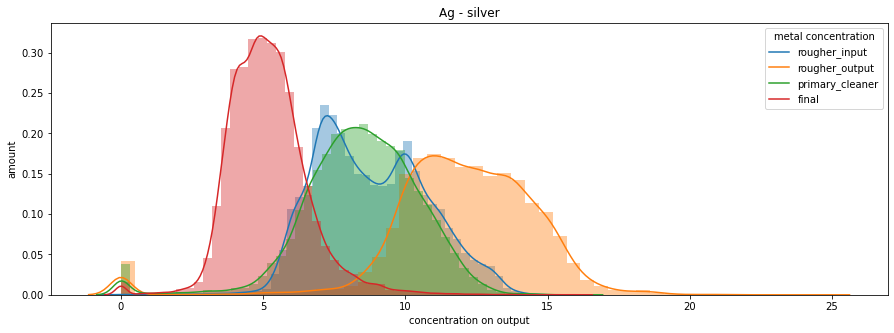

average concentration before flotation: 8.79
average concentration after flotation: 11.99
average concentration before primary cleaner: 8.44
average final concentration: 5.17


In [17]:
hist_concentration(df_full['rougher.input.feed_ag'],
                   df_full['rougher.output.concentrate_ag'], 
                   df_full['primary_cleaner.output.concentrate_ag'], 
                   df_full['final.output.concentrate_ag'],
                   'Ag - silver')

- концетрация серебра снижается на каждом этапе.

#### Свинец - `pb`

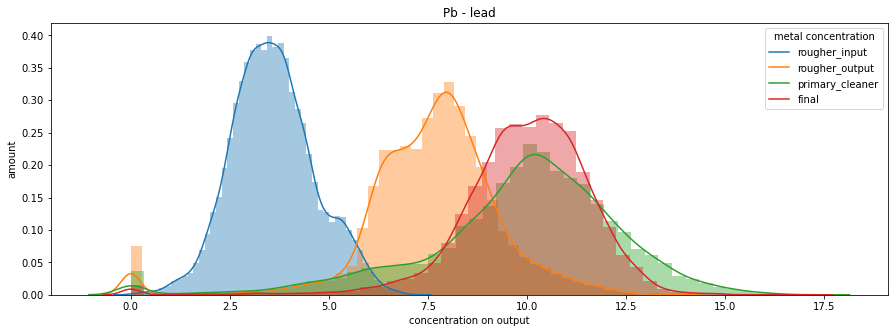

average concentration before flotation: 3.60
average concentration after flotation: 7.61
average concentration before primary cleaner: 9.83
average final concentration: 9.98


In [18]:
hist_concentration(df_full['rougher.input.feed_pb'],
                   df_full['rougher.output.concentrate_pb'], 
                   df_full['primary_cleaner.output.concentrate_pb'], 
                   df_full['final.output.concentrate_pb'],
                   'Pb - lead')

- концетрация свинца повышается на каждом этапе.

#### Золото - `au`

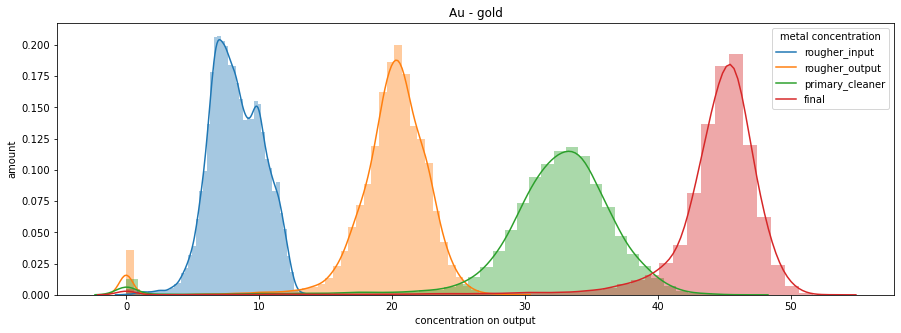

average concentration before flotation: 8.27
average concentration after flotation: 19.77
average concentration before primary cleaner: 32.12
average final concentration: 44.08


In [19]:
hist_concentration(df_full['rougher.input.feed_au'],
                   df_full['rougher.output.concentrate_au'], 
                   df_full['primary_cleaner.output.concentrate_au'], 
                   df_full['final.output.concentrate_au'],
                   'Au - gold')

- концетрация золота повышается на каждом этапе.

#### Вывод

- концентрация серебра понижается на каждом из этапов, т.к. приоритетным металлом является золото и остальные металлы отсеиваются;
- концетрация свинца растет на каждом из этапов, т.к. при использование азотнокислого выщелачивания в концентрате образуется сульфат свинца;
- концетрация золота повышается на каждом из этапов, т.к. приоритет и цель всего процесса - повышение концетрации золота.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

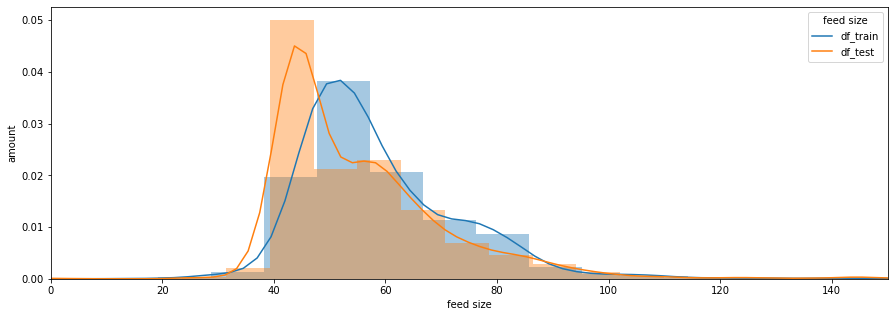

In [20]:
feed_size_train = df_train['rougher.input.feed_size']
feed_size_test = df_test['rougher.input.feed_size']

plt.figure(figsize=(15,5))
ax = sns.distplot(feed_size_train)
ax = sns.distplot(feed_size_test)
ax.set_xlim([0,150])
plt.legend(title='feed size', loc='upper right', labels=['df_train', 'df_test'])
plt.xlabel("feed size")
plt.ylabel("amount")
plt.show()

In [21]:
df_train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.117844
std         22.468112
min          9.659576
25%         48.985226
50%         55.376859
75%         65.953465
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [22]:
df_test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.955375
std        19.082490
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

#### Вывод

- распределение гранул до флотации - нормальное со смещением влево, как в обучающей `df_train`, так и в тестовой `df_test` выборке; 
- в обеих выборках присутсвуют выбросы.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [23]:
input_raw_concentrate = (df_full['rougher.input.feed_au'] +
                     df_full['rougher.input.feed_ag'] +
                     df_full['rougher.input.feed_pb'] +
                     df_full['rougher.input.feed_sol'])
rougher_output_concentrate = (df_full['rougher.output.concentrate_au'] + 
                              df_full['rougher.output.concentrate_ag'] + 
                              df_full['rougher.output.concentrate_pb'] +
                              df_full['rougher.output.concentrate_sol'])
primary_cleaner_output_concentrat = (df_full['primary_cleaner.output.concentrate_au'] + 
                                     df_full['primary_cleaner.output.concentrate_ag'] + 
                                     df_full['primary_cleaner.output.concentrate_pb'] +
                                     df_full['primary_cleaner.output.concentrate_sol'])
final_output_concentrate = (df_full['final.output.concentrate_au'] + 
                            df_full['final.output.concentrate_ag'] + 
                            df_full['final.output.concentrate_pb'] +
                            df_full['final.output.concentrate_sol'])

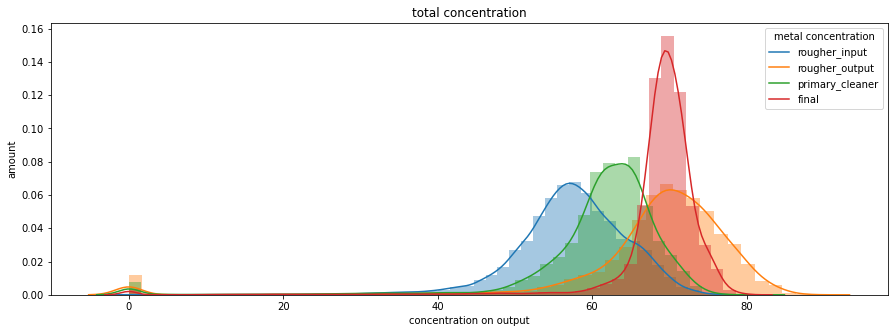

average concentration before flotation: 57.41
average concentration after flotation: 68.19
average concentration before primary cleaner: 60.95
average final concentration: 68.73


In [24]:
hist_concentration(input_raw_concentrate,
                   rougher_output_concentrate, 
                   primary_cleaner_output_concentrat, 
                   final_output_concentrate,
                   'total concentration')

Видим значения близкие к `0`. Удалим такие значения из обучающей выборки и посмотрим на результаты при обучении модели.

In [25]:
df_train_nozero = df_train.copy(deep=True)

In [26]:
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.input.feed_au"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.input.feed_ag"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.input.feed_pb"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.input.feed_sol"] < 1].index,axis = 0)

df_train_nozero = df_train.drop(index = df_train[df_train["rougher.output.concentrate_au"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.output.concentrate_ag"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.output.concentrate_pb"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["rougher.output.concentrate_sol"] < 1].index,axis = 0)

df_train_nozero = df_train.drop(index = df_train[df_train["primary_cleaner.output.concentrate_au"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["primary_cleaner.output.concentrate_ag"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["primary_cleaner.output.concentrate_pb"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["primary_cleaner.output.concentrate_sol"] < 1].index,axis = 0)

df_train_nozero = df_train.drop(index = df_train[df_train["final.output.concentrate_au"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["final.output.concentrate_ag"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["final.output.concentrate_pb"] < 1].index,axis = 0)
df_train_nozero = df_train.drop(index = df_train[df_train["final.output.concentrate_sol"] < 1].index,axis = 0)

#### Вывод

- в выборке `df_full` были замечены значения близкие к `0`. 
- создана выбрка - `df_train_nozero` - она содержит данные из обучающей выборки `df_train`, где были удалены значения близкие к `0`.

## Модель

### Напишем функцию для вычисления итоговой `sMAPE`.

$sMAPE= \frac{1}{N} \sum_{i=1}^{N} \frac {|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2} \times 100\% $

$Final\hspace{0.2cm}sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)$

In [27]:
def sMAPE(target, predictions):
    """фукция для вычисления sMAPE"""
    error = np.mean(abs(target - predictions) / ((abs(target)+abs(predictions)) / 2)) * 100
    return error

In [28]:
def final_sMAPE(sMAPE_rougher, sMAPE_final):
    """функция для вычисления итоговой sMAPE"""
    return (0.25 * sMAPE_rougher + 0.75 * sMAPE_final)

### Обучим модели и оцените их качество. 

Обучать модель будем при помощи алгоритмов - `RandomForestRegressor` и `DecisionTreeRegressor`.

#### Подготовим признаки

**Обучающая выборка с нулевыми значениями**

In [31]:
features_train_rougher = df_train.loc[:,df_test.columns]
features_train_rougher = features_train_rougher.drop(['rougher.output.recovery', 'final.output.recovery'],axis = 1)
target_train_rougher = df_train['rougher.output.recovery']
features_train_final = features_train_rougher 
target_train_final = df_train['final.output.recovery']

**Обучающая выборка без нулевых значений**

In [33]:
features_train_nozero_rougher = df_train_nozero.loc[:,df_test.columns]
features_train_nozero_rougher = features_train_nozero_rougher.drop(['rougher.output.recovery', 'final.output.recovery'],axis = 1)
target_train_nozero_rougher = df_train_nozero['rougher.output.recovery']
features_train_nozero_final = features_train_nozero_rougher 
target_train_nozero_final = df_train_nozero['final.output.recovery']

#### Инициализация `pipeline`

In [34]:
custom_score = make_scorer(sMAPE,greater_is_better=False)

In [35]:
model_RF = make_pipeline(RandomForestRegressor())
model_DT = make_pipeline(DecisionTreeRegressor())

In [36]:
params_RF = {'randomforestregressor__n_estimators':[5,100],
             'randomforestregressor__max_depth':[1,10]}
params_DT= {'decisiontreeregressor__max_depth':[1,10]}

In [37]:
grid_rougher_RF = GridSearchCV(model_RF, param_grid = params_RF, scoring=custom_score)
grid_final_RF = GridSearchCV(model_RF, param_grid = params_RF, scoring=custom_score)
grid_rougher_DT = GridSearchCV(model_DT, param_grid = params_DT, scoring=custom_score)
grid_final_DT = GridSearchCV(model_DT, param_grid = params_DT, scoring=custom_score)

In [38]:
grid_rougher_RF_nozero = GridSearchCV(model_RF, param_grid = params_RF, scoring=custom_score)
grid_final_RF_nozero = GridSearchCV(model_RF, param_grid = params_RF, scoring=custom_score)
grid_rougher_DT_nozero = GridSearchCV(model_DT, param_grid = params_DT, scoring=custom_score)
grid_final_DT_nozero = GridSearchCV(model_DT, param_grid = params_DT, scoring=custom_score)

#### Обучение модели с подбором гиперпараметров

##### На признаках с нулевыми значениями

In [39]:
grid_rougher_RF.fit(features_train_rougher, target_train_rougher)
grid_final_RF.fit(features_train_final, target_train_final)
grid_rougher_DT.fit(features_train_rougher, target_train_rougher)
grid_final_DT.fit(features_train_final, target_train_final)

GridSearchCV(estimator=Pipeline(steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [1, 10]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [40]:
print('best models')
print(grid_rougher_RF.best_estimator_, grid_rougher_RF.best_params_)
print(grid_final_RF.best_estimator_, grid_final_RF.best_params_)
print(grid_rougher_DT.best_estimator_, grid_rougher_DT.best_params_)
print(grid_final_DT.best_estimator_, grid_final_DT.best_params_)

best models
Pipeline(steps=[('randomforestregressor', RandomForestRegressor(max_depth=1))]) {'randomforestregressor__max_depth': 1, 'randomforestregressor__n_estimators': 100}
Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=1, n_estimators=5))]) {'randomforestregressor__max_depth': 1, 'randomforestregressor__n_estimators': 5}
Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))]) {'decisiontreeregressor__max_depth': 1}
Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))]) {'decisiontreeregressor__max_depth': 1}


##### На признаках без нулевых значений

In [41]:
grid_rougher_RF_nozero.fit(features_train_nozero_rougher, target_train_nozero_rougher)
grid_final_RF_nozero.fit(features_train_nozero_final, target_train_nozero_final)
grid_rougher_DT_nozero.fit(features_train_nozero_rougher, target_train_nozero_rougher)
grid_final_DT_nozero.fit(features_train_nozero_final, target_train_nozero_final)

GridSearchCV(estimator=Pipeline(steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [1, 10]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [42]:
print('best models')
print(grid_rougher_RF_nozero.best_estimator_, grid_rougher_RF_nozero.best_params_)
print(grid_final_RF_nozero.best_estimator_, grid_final_RF_nozero.best_params_)
print(grid_rougher_DT_nozero.best_estimator_, grid_rougher_DT_nozero.best_params_)
print(grid_final_DT_nozero.best_estimator_, grid_final_DT_nozero.best_params_)

best models
Pipeline(steps=[('randomforestregressor', RandomForestRegressor(max_depth=10))]) {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 100}
Pipeline(steps=[('randomforestregressor', RandomForestRegressor(max_depth=10))]) {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 100}
Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))]) {'decisiontreeregressor__max_depth': 1}
Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))]) {'decisiontreeregressor__max_depth': 1}


##### Сохранием лучшие результаты в переменные

In [43]:
best_score_rougher_RF = grid_rougher_RF.best_score_
best_score_final_RF = grid_final_RF.best_score_
best_score_rougher_DT = grid_rougher_DT.best_score_
best_score_final_DT = grid_final_DT.best_score_
best_score_rougher_RF_nozero = grid_rougher_RF_nozero.best_score_
best_score_final_RF_nozero = grid_final_RF_nozero.best_score_
best_score_rougher_DT_nozero = grid_rougher_DT_nozero.best_score_
best_score_final_DT_nozero = grid_final_DT_nozero.best_score_

#### Определим лучшую модель

In [44]:
print('df_train')
print('rougher')
print('RandomForestRegressor', best_score_rougher_RF, 'DecisionTreeRegressor', best_score_rougher_DT)
print('final')
print('RandomForestRegressor', best_score_final_RF, 'DecisionTreeRegressor', best_score_final_DT)
print()
print('df_train_nozero')
print('rougher')
print('RandomForestRegressor', best_score_rougher_RF_nozero, 'DecisionTreeRegressor', best_score_rougher_DT_nozero)
print('final')
print('RandomForestRegressor', best_score_final_RF_nozero, 'DecisionTreeRegressor', best_score_final_DT_nozero)

df_train
rougher
RandomForestRegressor -12.445858084025755 DecisionTreeRegressor -12.463448579275099
final
RandomForestRegressor -10.672154957182798 DecisionTreeRegressor -11.037567187433716

df_train_nozero
rougher
RandomForestRegressor -12.09010079576024 DecisionTreeRegressor -12.437907729685326
final
RandomForestRegressor -9.662836990094219 DecisionTreeRegressor -9.852999527983446


#### Итоговые `sMAPE` на тренировочной выборке

`RandomForestRegressor` на выборке `df_train`

In [45]:
final_sMAPE(best_score_rougher_RF, best_score_final_RF)

-11.115580738893538

`DecisionTreeRegressor` на выборке `df_train`

In [46]:
final_sMAPE(best_score_rougher_DT, best_score_final_DT)

-11.394037535394062

`RandomForestRegressor` на выборке `df_train_nozero`

In [47]:
final_sMAPE(best_score_rougher_RF_nozero, best_score_final_RF_nozero)

-10.269652941510724

`DecisionTreeRegressor` на выборке `df_train_nozero`

In [48]:
final_sMAPE(best_score_rougher_DT_nozero, best_score_final_DT_nozero)

-10.499226578408916

##### Вывод

Наилучший результат показала модель по алгоритму `RandomForestRegressor` на выборке с удаленными нулевыми значениями `df_train_nozero`. 
Наилучшие гиперпараметры:
- для `rougher.output.recovery` - `max_depth=10`, `n_estimators=100`
- для `final.output.recovery` - `max_depth=10`, `n_estimators=100`

#### Проверка модели на тестовой выборке

##### Удалим из тестовой выборки значения, равные `0`

In [49]:
df_test = df_test.drop(index = df_test[df_test['rougher.input.feed_au'] < 1].index,axis = 0)
df_test = df_test.drop(index = df_test[df_test['rougher.input.feed_ag'] < 1].index,axis = 0)
df_test = df_test.drop(index = df_test[df_test['rougher.input.feed_pb'] < 1].index,axis = 0)
df_test = df_test.drop(index = df_test[df_test['rougher.input.feed_sol'] < 1].index, axis = 0)

##### Подготовим признаки

In [51]:
features_test_rougher = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_test_rougher = df_test['rougher.output.recovery']
features_test_final = features_test_rougher
target_test_final = df_test['final.output.recovery']

##### Проверим модель на тестовой выборке

In [52]:
model_rougher = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=state)
model_final = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=state)
model_rougher.fit(features_train_nozero_rougher, target_train_nozero_rougher)
model_final.fit(features_train_nozero_final, target_train_nozero_final)
predictions_rougher = model_rougher.predict(features_test_rougher)
predictions_final = model_final.predict(features_test_final)
sMAPE_rougher = sMAPE(target_test_rougher, predictions_rougher)
sMAPE_final = sMAPE(target_test_final, predictions_final)

##### Симметричное среднее абсолютное процентное отклонение на тестовой выборке

In [53]:
final_sMAPE(sMAPE_rougher, sMAPE_final)

9.755613028106731

##### Инициализируем и обучим константную модель для проверки качества обучения тестовой выборки

In [54]:
check_rougher = DummyRegressor(strategy='mean')
check_final = DummyRegressor(strategy='mean')

In [55]:
check_rougher.fit(features_train_nozero_rougher, target_train_nozero_rougher)
check_final.fit(features_train_nozero_final, target_train_nozero_final)

DummyRegressor()

In [56]:
predictions_check_rougher = check_rougher.predict(features_test_rougher)
predictions_check_final = check_final.predict(features_test_final)
sMAPE_check_rougher = sMAPE(target_test_rougher, predictions_check_rougher)
sMAPE_check_final = sMAPE(target_test_final, predictions_check_final)

In [57]:
final_sMAPE(sMAPE_check_rougher, sMAPE_check_final)

10.033951601731092

### Вывод

- модель обучена по алгоритму `RandomForestRegressor` на выборке с удаленными нулевыми значениями `df_train_nozero`;
- симметричное среднее абсолютное процентное отклонение на тестовой выборке приемлемо, т.к. ниже чем у константной модели.

## Общий вывод

- все датасеты содержат пустые значения;
- в тестовой выборке отсутствут данные о выходных характеристиках металлов, отвальных хвостах и рассчетных характеристиках;
- модель обучена по алгоритму `RandomForestRegressor` на выборке с удаленными нулевыми значениями `df_train_nozero`;
- симметричное среднее абсолютное процентное отклонение на тестовой выборке приемлемо, т.к. оно ниже чем у константной модели.